# 读入拟合好的参数，看流量，做控制，Logistic 函数作为调控函数

In [1]:
import csv
import json
import linecache
import datetime
import sys
import numpy as np
import random
from scipy.sparse import *
from scipy import *
import scipy as sp
import matplotlib.pyplot as plt
import os.path
import matplotlib
import copy
import pandas as pd
from scipy import stats
from tempfile import TemporaryFile
import pickle
from scipy.integrate import odeint
from torchdiffeq import odeint as dodeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import country_converter as coco

def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()
    

## Load all data

In [2]:
# 加载拟基本数据和参数
# 参数说明：
#1、first_date：2020年1月1日，是我们的时间0点
#2、start_date: 2019年12月1日，是病例数据起始的0点
#3、all_cumconfirm_cases: 是一个time_length*国家数的而为数组，记录了某一天现存的确诊病例数，这里time_length就是12-1日到4-15日的时间
#4、all_cumexist_cases：是一个time_length*国家数的而为数组，记录了某一天累积的确诊病例数
#7、first_cases: 在2019年12月1日，中国的确诊病例数
#8、字典nodes，国家名称作为key，国家在nodes中的位置作为value，这个值也是后面各个数组的国家索引
#9、population，一个数组，各个国家的人口数
#10、fijt：一个列表，存储了从2019-12-1到2020-12-31的每一天的流量矩阵，其中fij表示从i国家到j国家的航空流量除以i国家的人口数
f=open('all_data_4_15.pkl', 'rb')
output = pickle.load(f)
f.close()
all_cumconfirm_cases = output['cases'][0]
all_cumexist_cases = output['cases'][1]
first_cases = output['cases'][2]
first_date = output['cases'][3]
start_date = output['cases'][4]
time_cases = output['cases'][5]
nodes = output['nodes']
population = output['population']
fijt = output['fijt']

len(fijt)


396

In [176]:
# 加载拟合优化后得到的基本参数，主要包括每个国家的lambdas，每个国家的t0s，每个国家的alphas，betas和初始的未确诊病例数
f=open('logs/inidividual_parameters_4_15_log_lambda.pkl', 'rb')
aaa = pickle.load(f)
f.close()
aaa

{'Uruguay': {'alphas': array([0.78987896], dtype=float32),
  'betas': array([0.35041288], dtype=float32),
  'initial_unconfirmed': array([47.004208], dtype=float32),
  't0s': array([0.], dtype=float32),
  'lambds': array([0.58414096], dtype=float32)},
 'Cameroon': {'alphas': array([0.99996305], dtype=float32),
  'betas': array([0.32498485], dtype=float32),
  'initial_unconfirmed': array([1.9517311], dtype=float32),
  't0s': array([23.028774], dtype=float32),
  'lambds': array([0.8770951], dtype=float32)},
 'Kuwait': {'alphas': array([0.99999714], dtype=float32),
  'betas': array([0.18190639], dtype=float32),
  'initial_unconfirmed': array([35.124413], dtype=float32),
  't0s': array([4.891478], dtype=float32),
  'lambds': array([0.0004921], dtype=float32)},
 'Bahrain': {'alphas': array([0.999998], dtype=float32),
  'betas': array([0.17100467], dtype=float32),
  'initial_unconfirmed': array([51.48337], dtype=float32),
  't0s': array([4.719178], dtype=float32),
  'lambds': array([0.002270

## functions

我们使用的动力系统方程为：
 
 $\partial u_i/\partial t = \xi(t) \beta_i u_i s_i - u_i/T_C + \sum_j F_{ji} u_j - \sum_j F_{ij} u_i$
 
 $\partial c_i/\partial t = \alpha_i u_i/T_C - c_i/T_R$
 
 $\partial s_i/\partial t = - \xi(t) \beta_i u_i s_i + \sum_j F_{ji} s_j - \sum_j F_{ij} s_i$
 
 其中，$\xi(t)$ 为干预项，定义为：
 
 $\xi(t) = \frac{1}{1+\exp(\lambda_i(t-t0_i)-\ln(1/\epsilon-1))}$
 
 $T_C$为病例从未确诊转化为确诊或康复或死亡的平均时间，
 
 $\alpha_i$为i国家这些转移出的未确诊病例中被确诊的概率。
 
 $\beta_i$为i国家的感染率，$\beta_i * T_C = R_{0i}$即i国家的$R_0$，
 
 $T_R$为确诊病例转移到恢复态或死亡的平均时间。
 
 $F_{ij}$为从i到j国家的航空流量除以i国家的人口
 
 $u_i, c_i, s_i$分别为i国家的未确诊、确诊和易感态的人口占该国总人口的比例
 
 $\lambda_i$为i国的干预力度
 
 $t0_i$为i国的干预起始时间
 
 $\epsilon$为可接受的r0降低到的比例

In [177]:
# 上述微分方程模拟器，分成了两个，一个是多节点有网络的，底下的是单一节点的
def intervention(parameters,t):
    epsilon = parameters['epsilon']
    lambd = parameters['lambds']
    t0 = parameters['t0s']
    tstar = parameters['tstar']
    lambd2 = parameters['lambds2']
    exp1 = np.exp(lambd * (t - t0) - np.log(1/epsilon-1))
    decay = 1/(1+exp1)
    if tstar>0:
        #tstar = x0 + np.log((1-relax*epsilon)/(relax*epsilon+eta-1))
        exp2 = np.exp(lambd * (2*tstar - t - t0) - np.log(1/epsilon-1))
        decay1 += 1/(1+exp2)
    return decay
def np_ode(states, t, parameters, fijt, population):
    #print(t, states[0])
    sz = states.shape[0] // 5
    us = states[:sz]
    cs = states[sz:2*sz]
    ss = states[2*sz:3*sz]
    interval = parameters['interval']
    tidx = int(t * interval)
    if tidx >= len(fijt):
        fij = fijt[len(fijt)-1]
    else:
        fij = fijt[tidx]
    uterm = (us * population).dot(fij) / population - us * np.sum(fij,1)
    sterm = (ss * population).dot(fij) / population - ss * np.sum(fij,1)
    beta = parameters['beta']
    t_c = parameters['tc']
    t_r = parameters['tr']
    alphas = parameters['alphas']
    cross_term = beta * us * ss * intervention(parameters, t)
    #cross_term = beta * us * ss
    delta_u = cross_term - us / t_c + uterm
    delta_c = alphas * us / t_c - cs / t_r 
    delta_s = - cross_term + sterm
    domestic = cross_term
    virus_influx = (us * population).dot(fij) / population
    output = np.r_[delta_u, delta_c, delta_s, virus_influx, domestic]
    #records1.append(np.r_[delta_u, delta_c, delta_s])
    #records2.append(np.r_[us, cs, ss])
    return output
def single_np_ode(state, t, parameters, population):
    us = state[0]
    cs = state[1]
    ss = state[2]
    beta = parameters['beta']
    t_c = parameters['tc']
    t_r = parameters['tr']
    alpha = parameters['alpha']
    cross_term = beta * us * ss * intervention(parameters, t)
    
    delta_u = cross_term - us / t_c
    delta_c = alpha * us / t_c - cs / t_r 
    delta_s = - cross_term
    output = np.r_[delta_u, delta_c, delta_s]
    return output
    

Uruguay


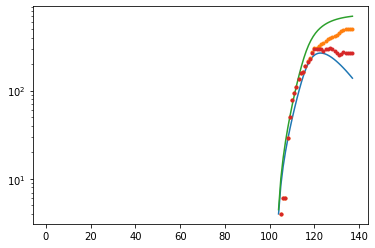

Cameroon


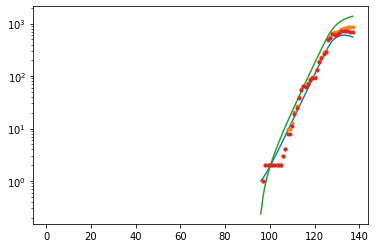

Kuwait


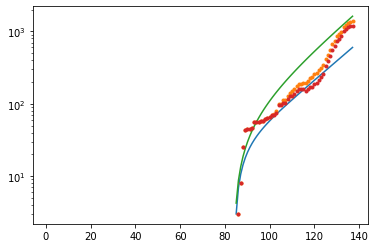

Bahrain


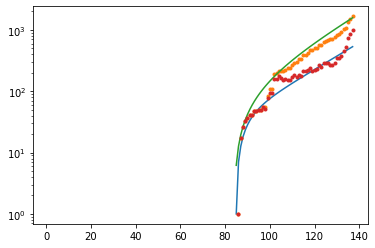

Christmas Island
Germany


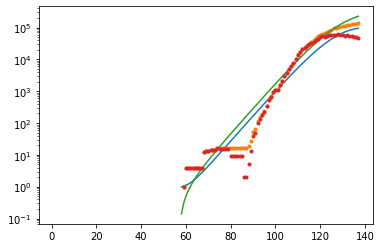

Cuba


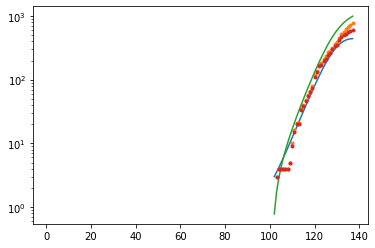

St. Helena
Tuvalu
Turks and Caicos Islands


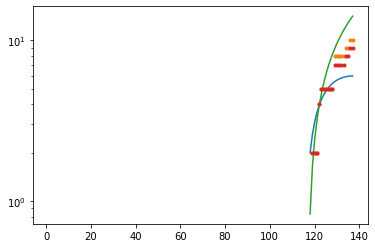

Sweden


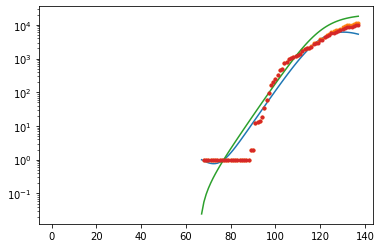

Italy


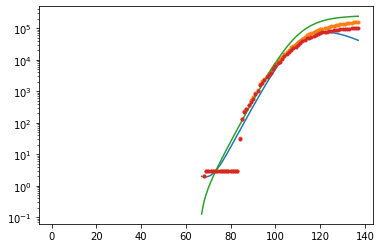

Nepal


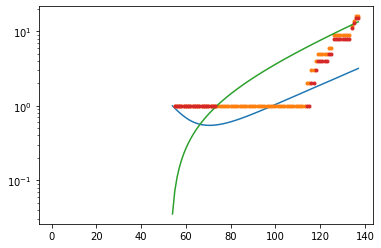

Norfolk Island
Aland Islands
Thailand


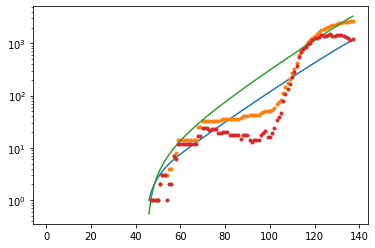

Equatorial Guinea


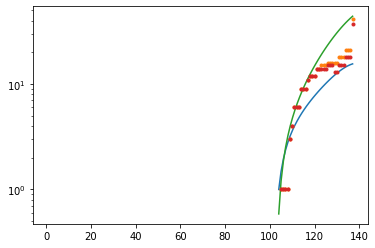

Uzbekistan


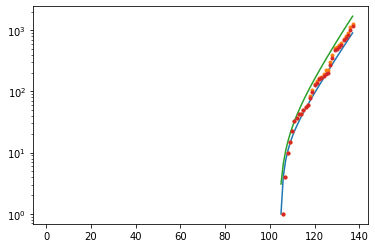

Austria


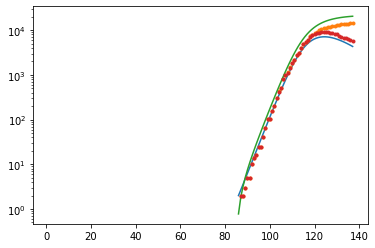

Lithuania


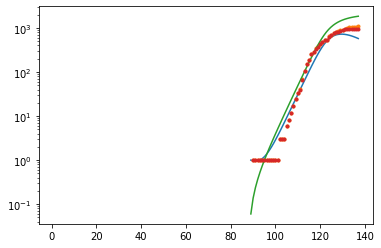

Hungary


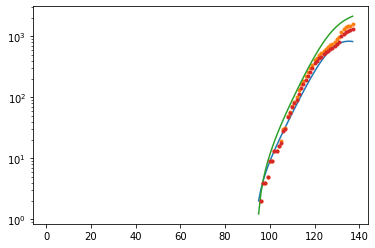

Vietnam


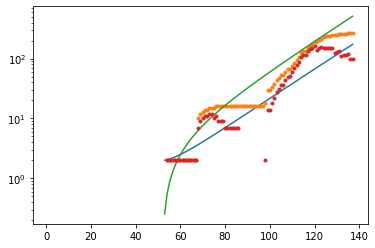

Montserrat


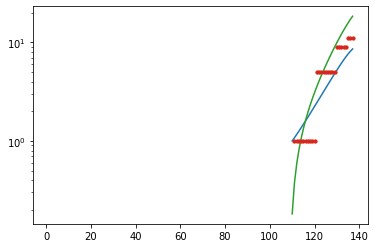

Faeroe Islands


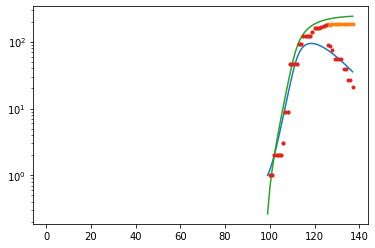

Turkmenistan
Kyrgyz Republic


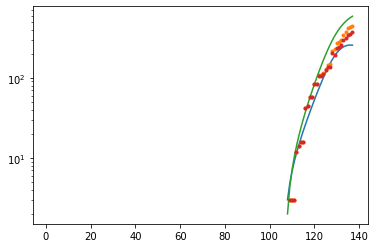

Maldives


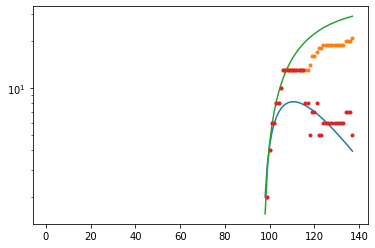

Isle of Man


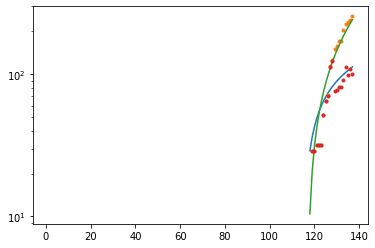

Burkina Faso


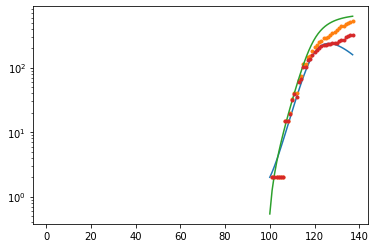

Greece


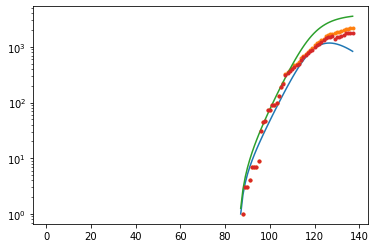

Cyprus


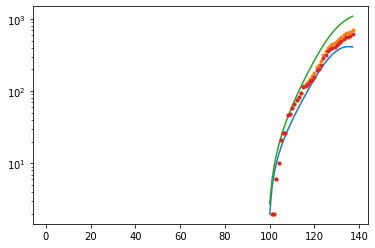

Puerto Rico


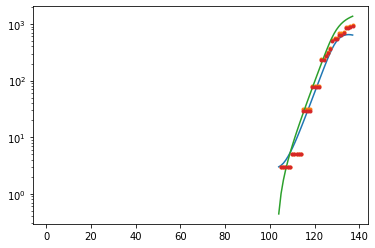

Bahamas


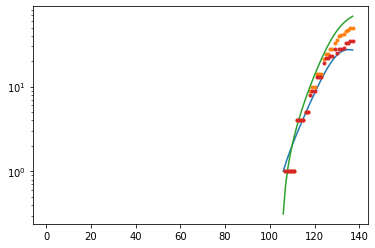

Antarctica
Finland


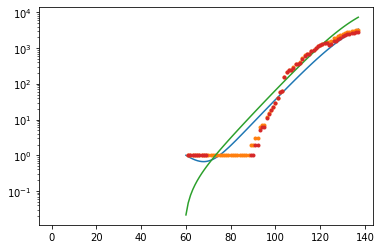

Japan


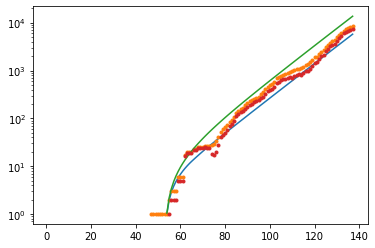

Martinique


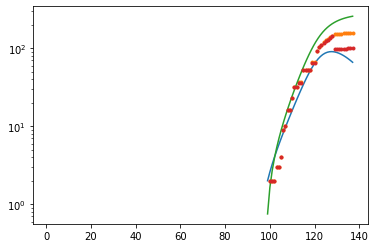

Nauru
Bermuda


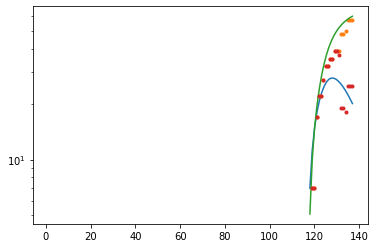

Antigua and Barbuda
Mozambique


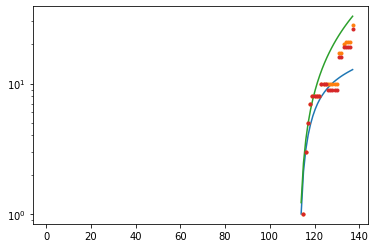

Sint Maarten
Malawi


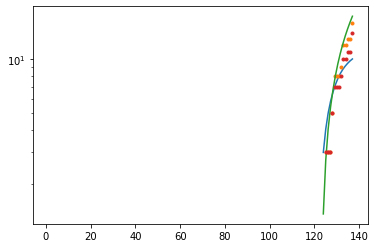

French Polynesia


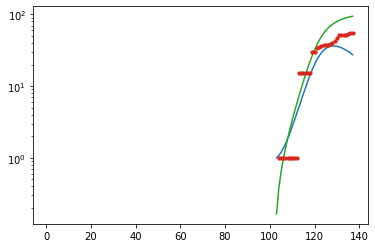

Rwanda


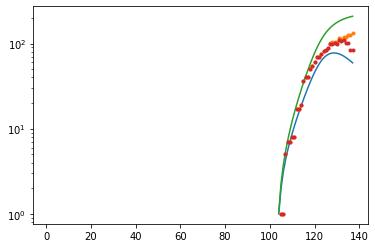

South Africa


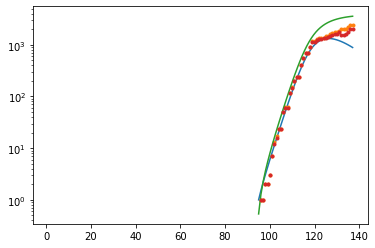

Bonaire, Saint Eustatius and Saba
Barbados


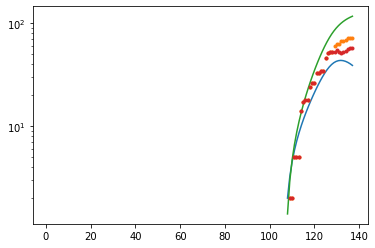

Luxembourg


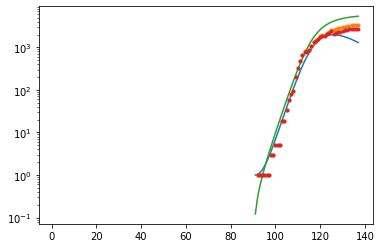

Wallis and Futuna Islands
Guinea-Bissau


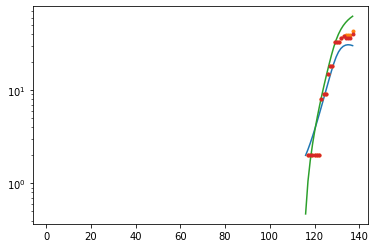

St. Barths
Gibraltar


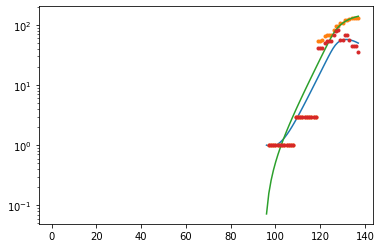

Jamaica


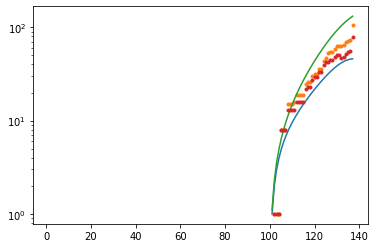

Malaysia


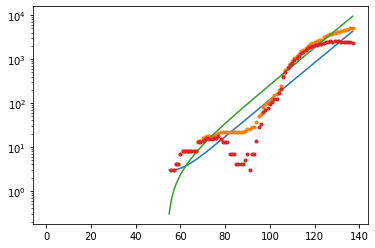

Sri Lanka


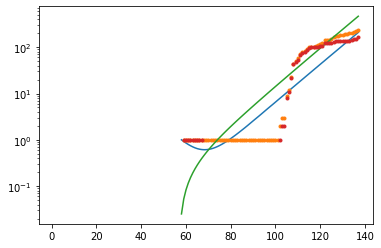

Palau
Ecuador


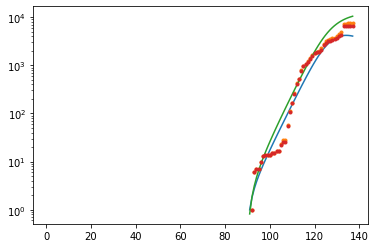

Albania


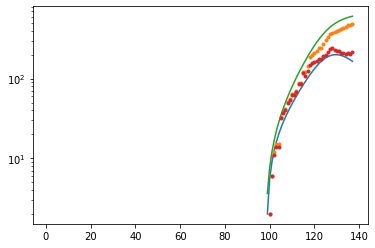

Bhutan


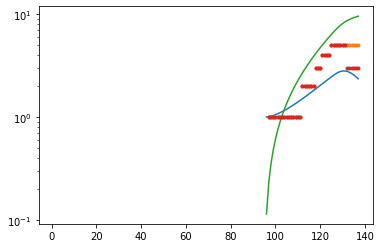

Gabon


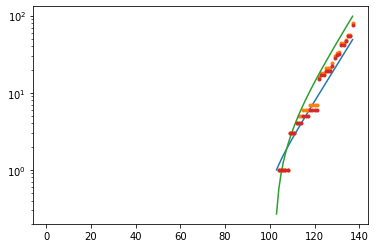

Seychelles


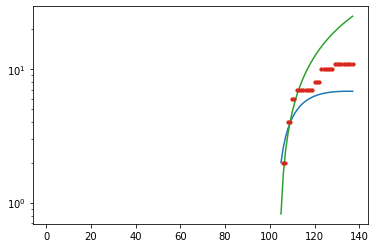

Indonesia


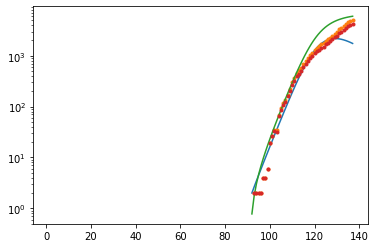

Mauritius


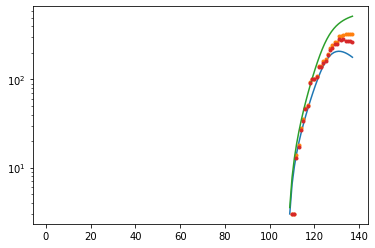

Venezuela


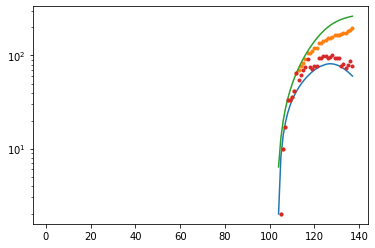

Sao Tome and Principe


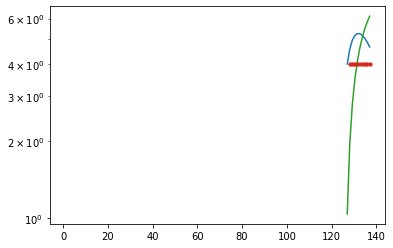

Slovenia


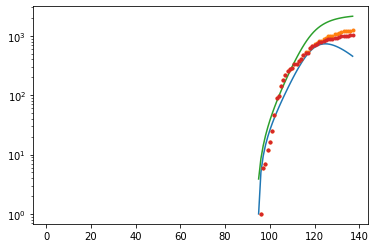

Switzerland


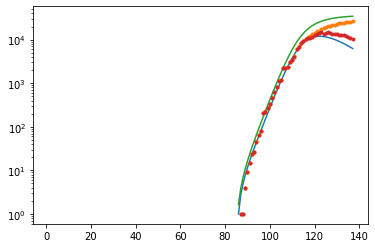

Angola


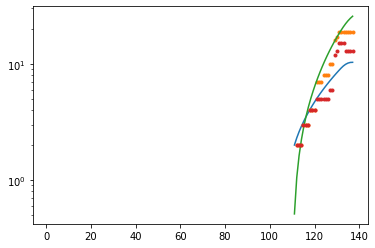

Bulgaria


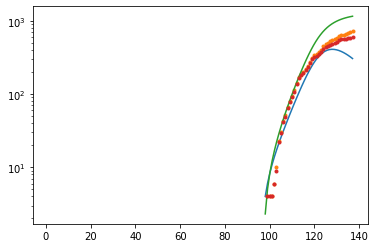

New Zealand


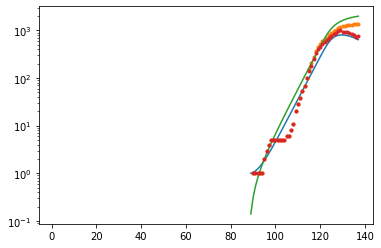

Congo Republic


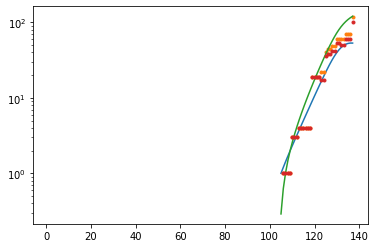

Curacao
Botswana


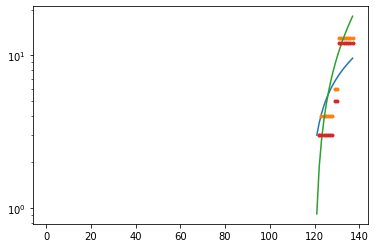

Niue
Iraq


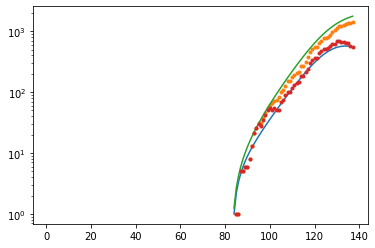

Reunion


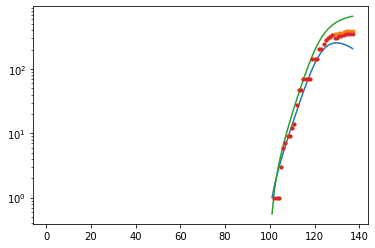

Guyana


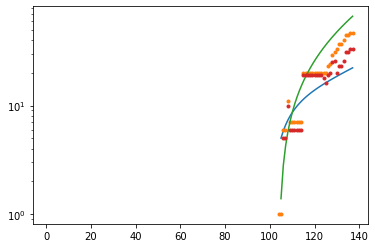

Fiji


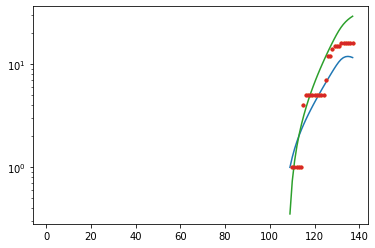

Czech Republic


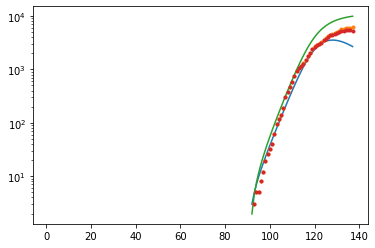

Guinea


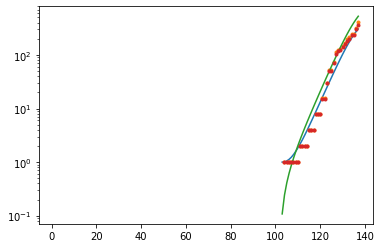

Uganda


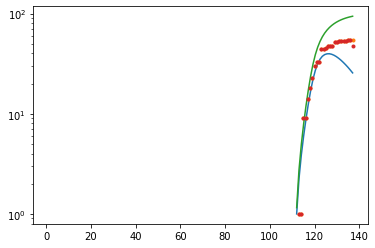

Grenada


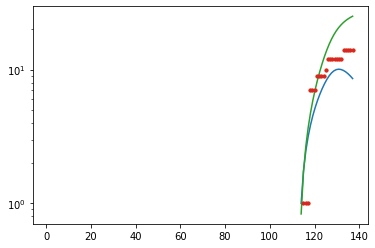

Haiti


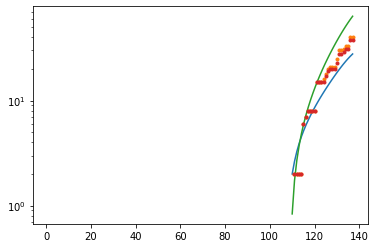

Sudan


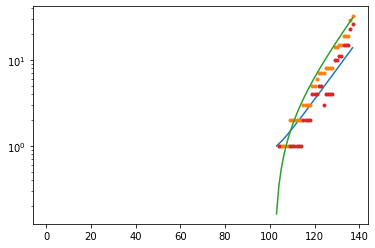

Peru


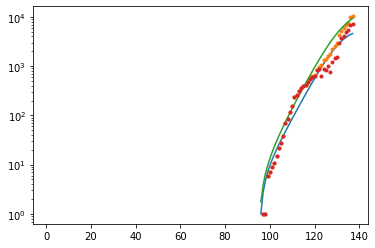

Netherlands


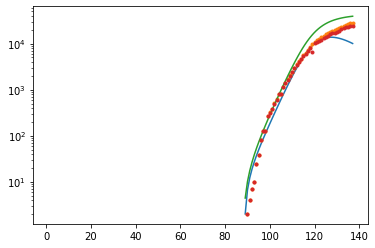

Turkey


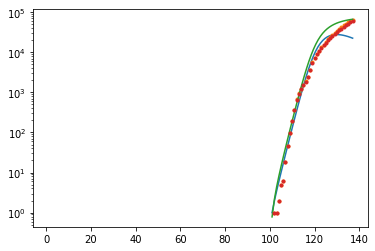

Panama


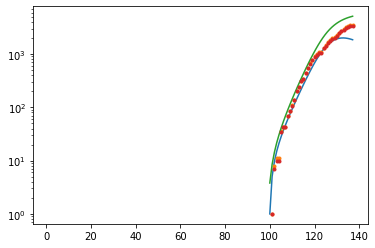

Dominica


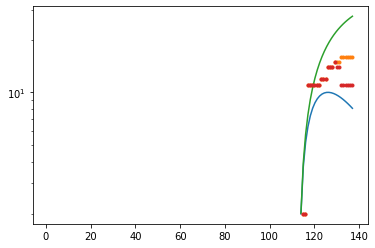

Norway


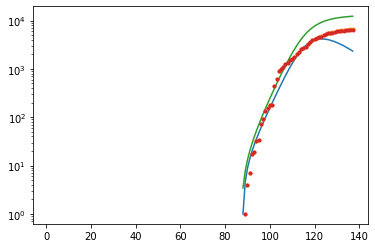

Timor-Leste


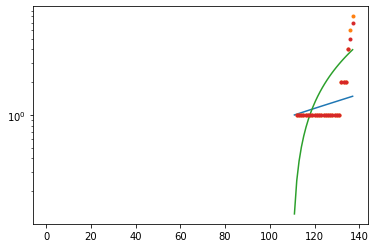

Montenegro


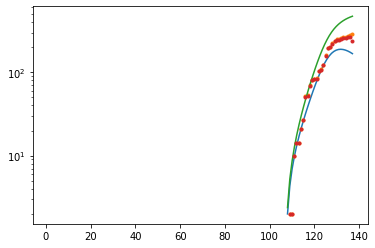

Somalia


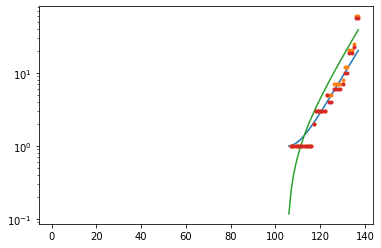

Eswatini


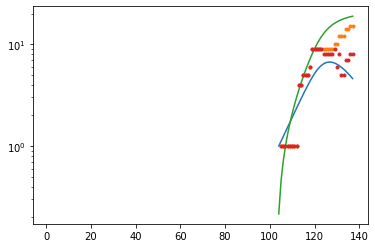

Liechtenstein


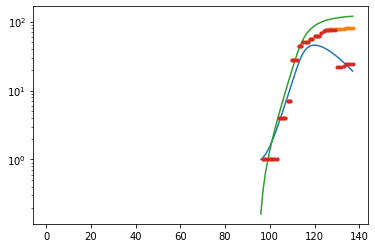

Slovakia


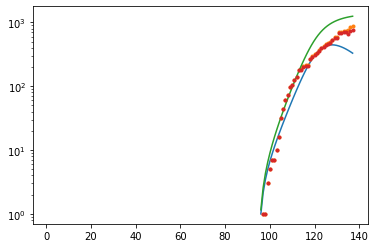

Ghana


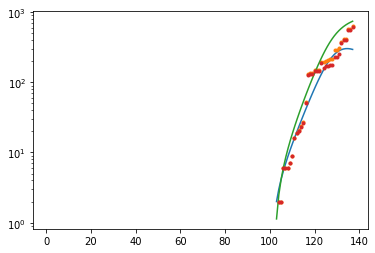

DR Congo


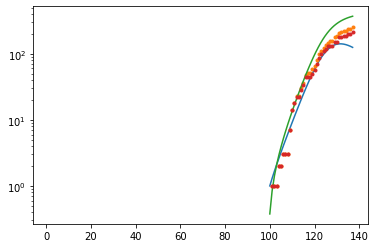

Singapore


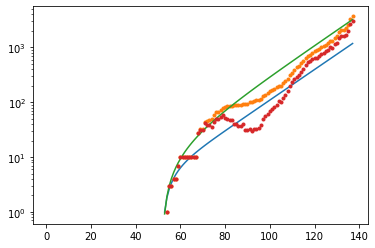

Paraguay


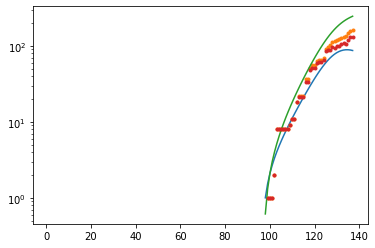

Georgia
Bolivia


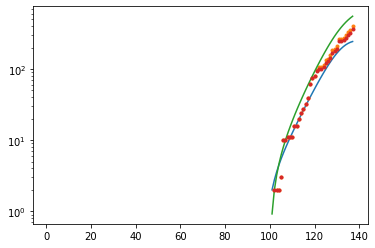

Kiribati
North Korea
Oman


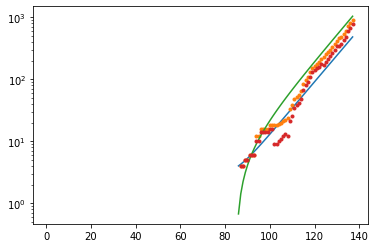

Cook Islands
Canada


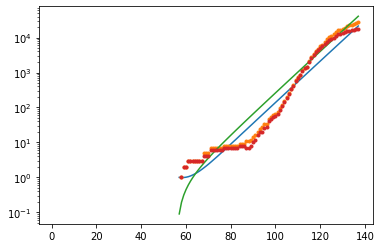

South Korea


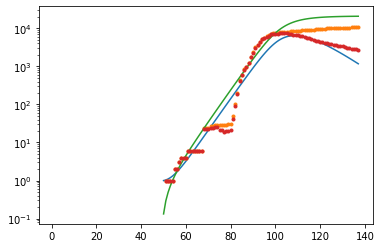

Croatia


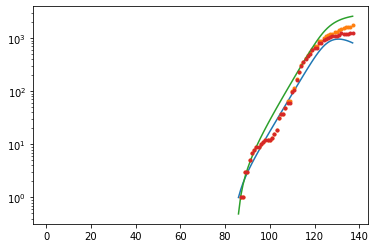

Bosnia and Herzegovina


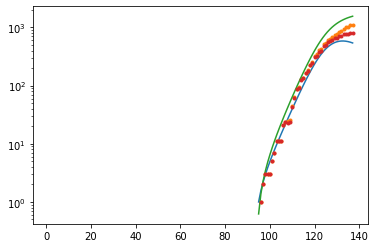

Malta


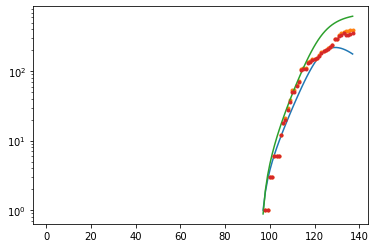

Niger


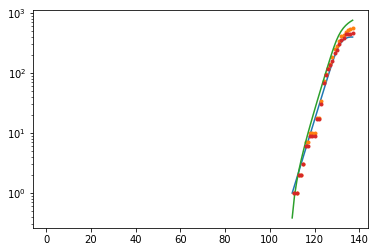

Tonga
Cocos (Keeling) Islands
Armenia


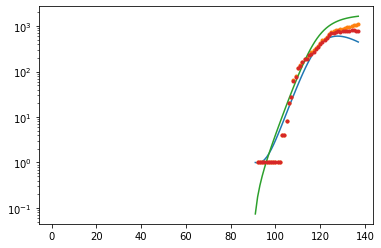

Bouvet Island
Dominican Republic


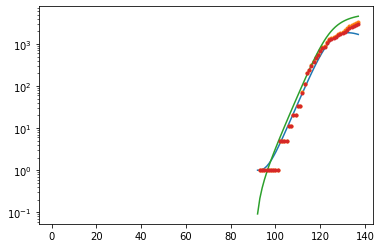

Suriname


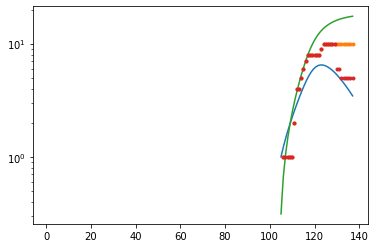

St. Pierre and Miquelon


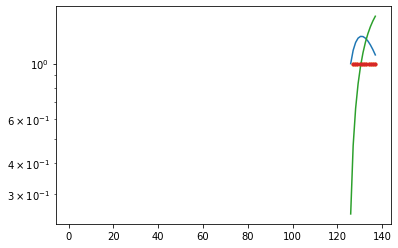

Guadeloupe


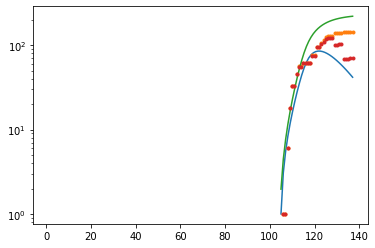

Svalbard and Jan Mayen Islands
Romania


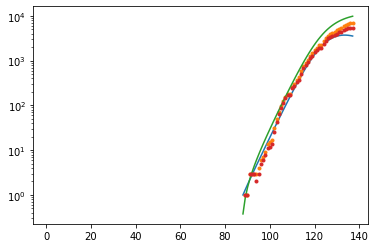

Micronesia, Fed. Sts.
Moldova


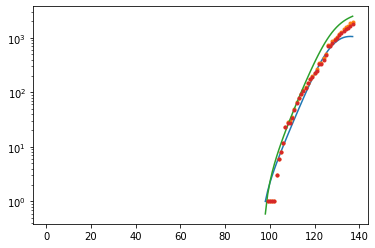

Namibia


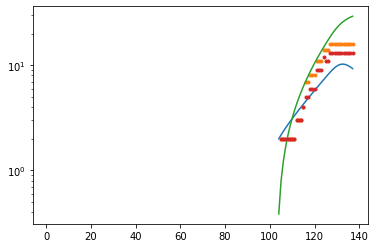

Mexico


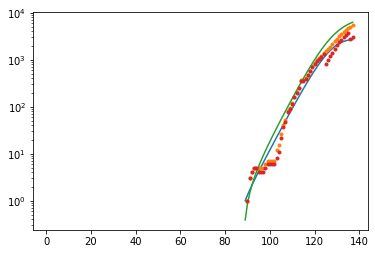

Gambia


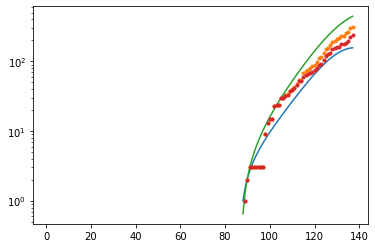

Poland


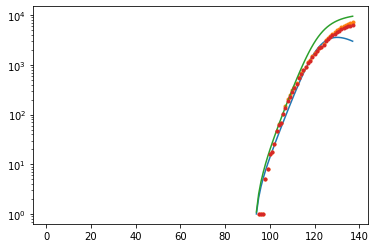

Pitcairn
St. Vincent and the Grenadines


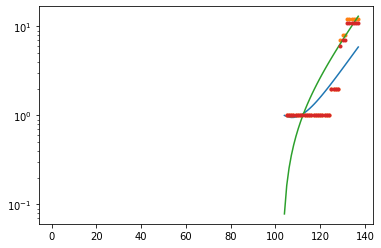

Liberia


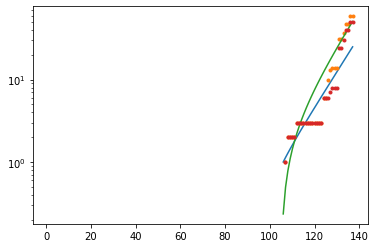

Spain


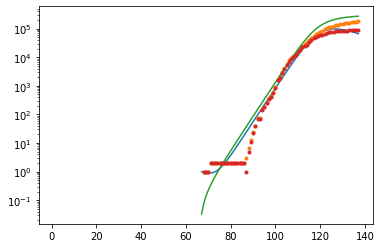

Pakistan


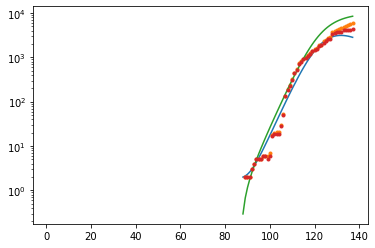

Mali


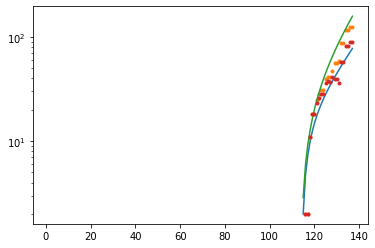

Madagascar


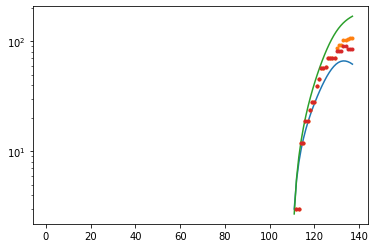

Zimbabwe


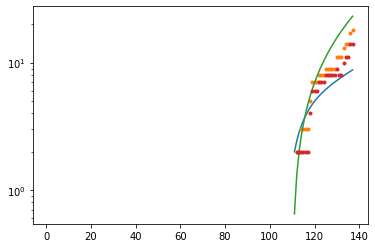

Macedonia
Sierra Leone


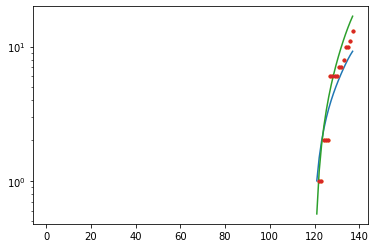

United Kingdom


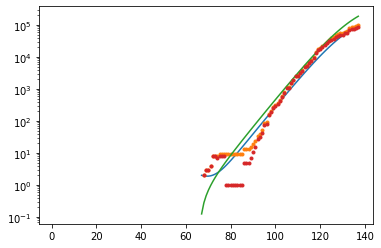

Central African Republic


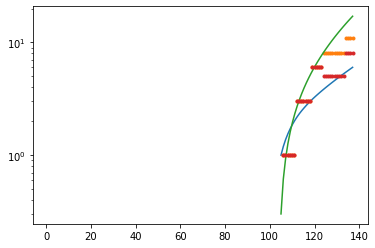

Burundi


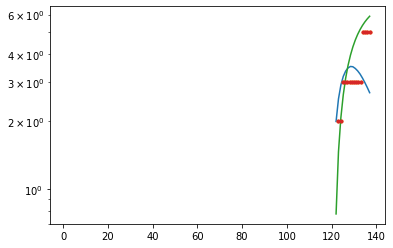

Estonia


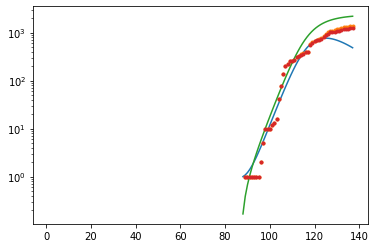

Iceland


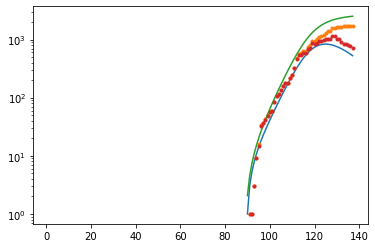

Northern Mariana Islands


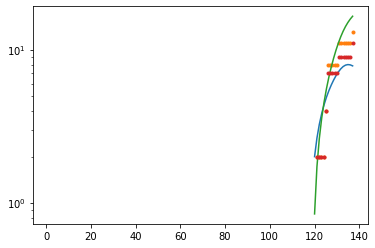

Chile


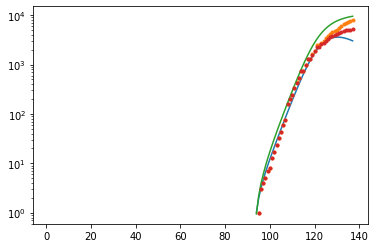

French Guiana


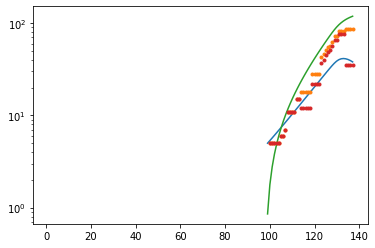

Saint-Martin
Monaco


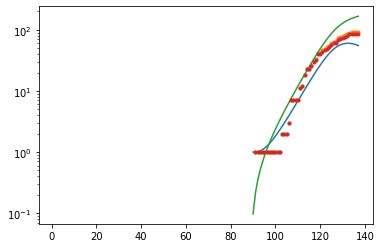

Philippines


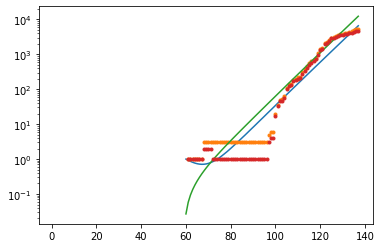

Zambia


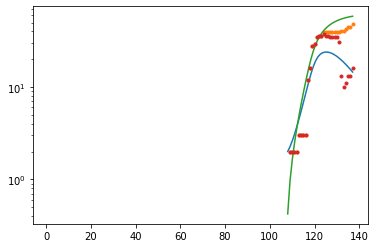

San Marino


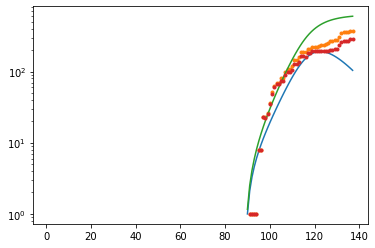

Trinidad and Tobago


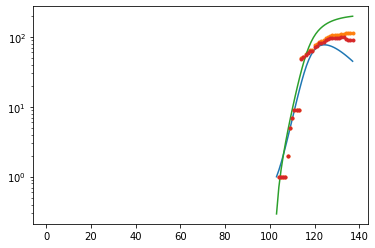

Djibouti


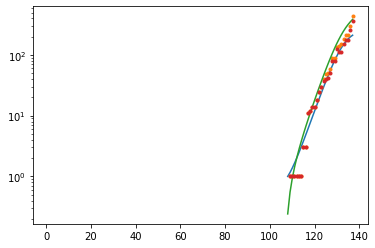

Mauritania


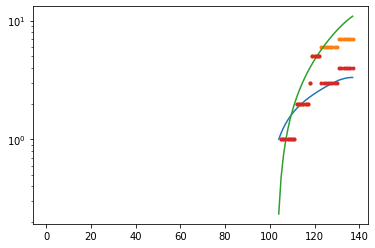

Ireland


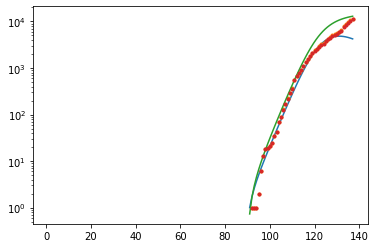

Myanmar


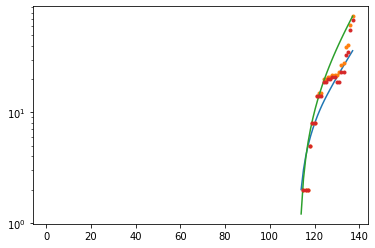

Kosovo
Vatican


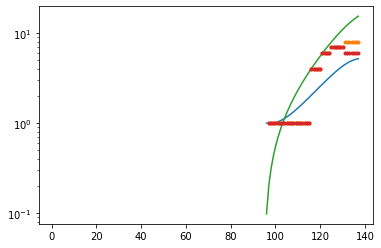

Ukraine


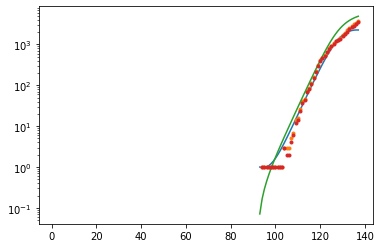

Afghanistan


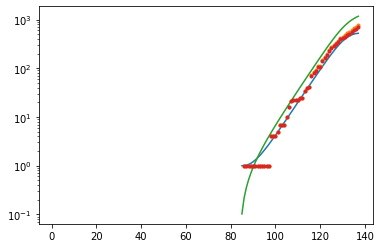

Laos


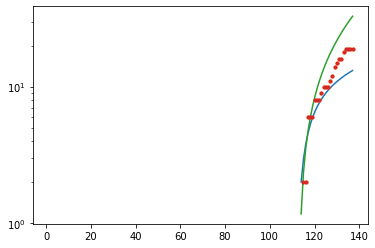

Comoros
Israel


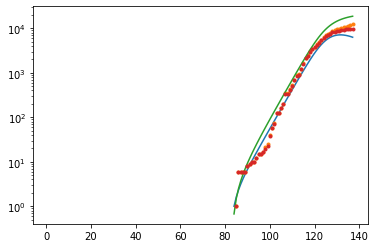

Greenland


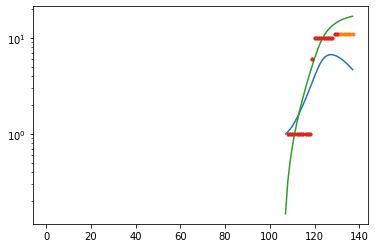

Kenya


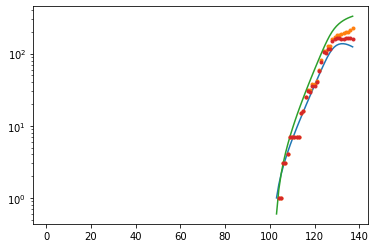

Mongolia


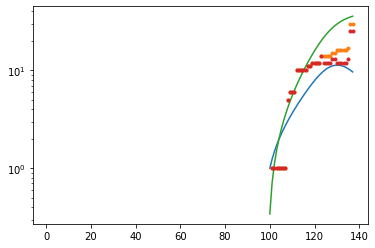

Cabo Verde


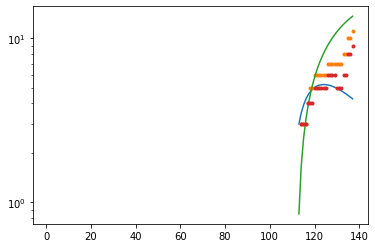

Lesotho
South Georgia and South Sandwich Is.
Guatemala


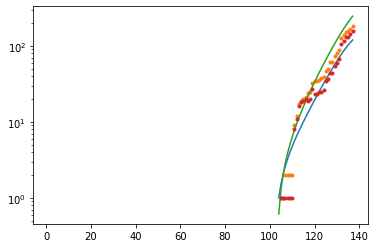

Anguilla


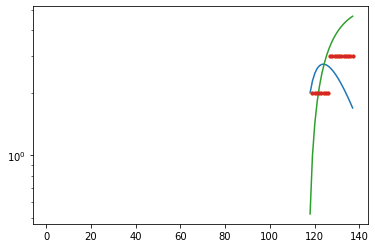

Yemen


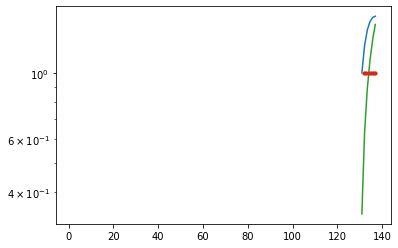

Honduras


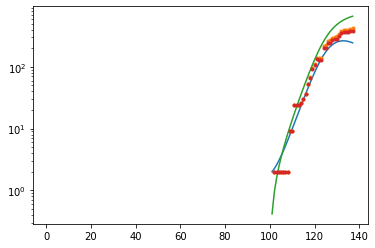

New Caledonia


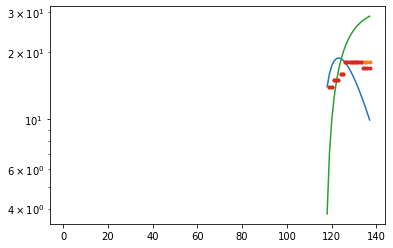

French Southern Territories
Algeria


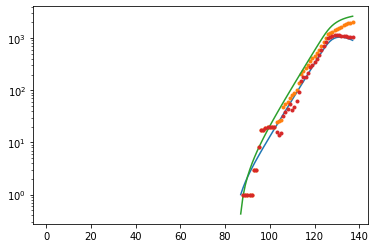

Libya


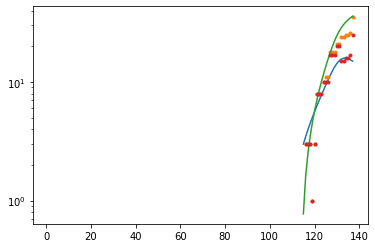

Benin


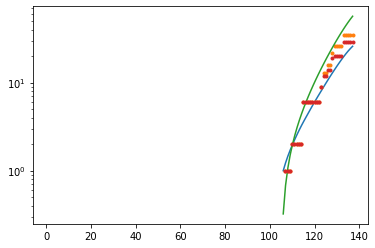

India


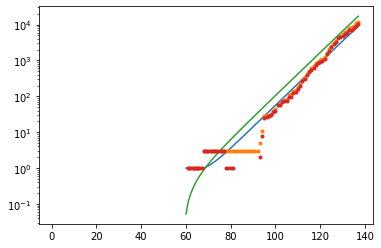

Russia


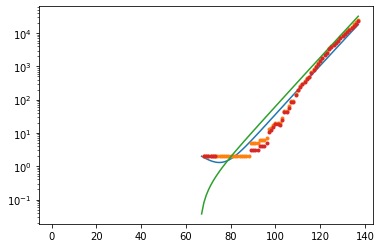

Solomon Islands
Argentina


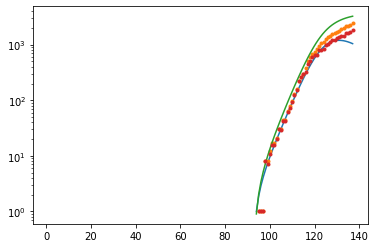

Jordan


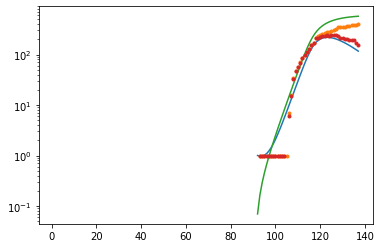

Eritrea


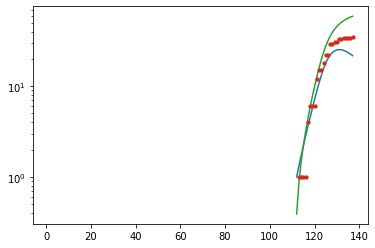

Syria


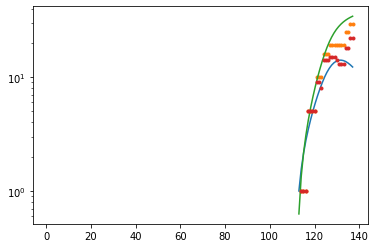

Australia


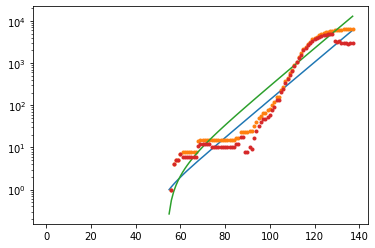

China


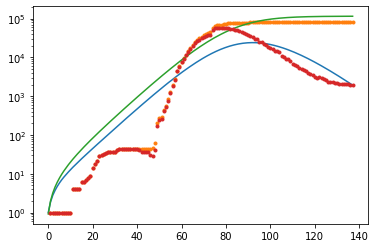

Lebanon


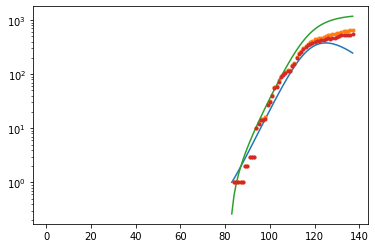

Vanuatu
Senegal


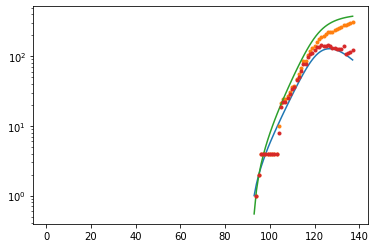

Denmark


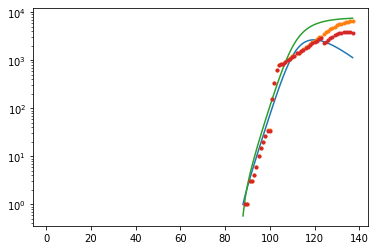

Tajikistan
Mayotte


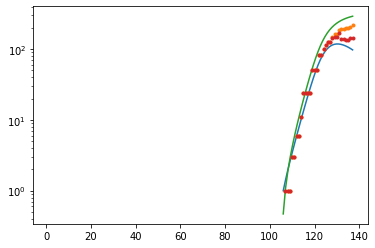

Marshall Islands
Iran


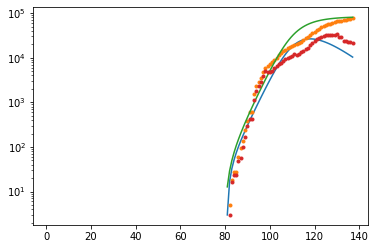

Nicaragua


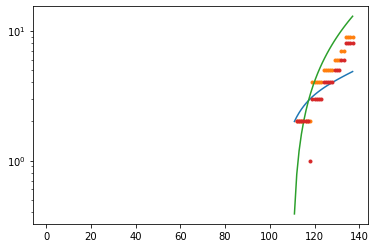

Ethiopia


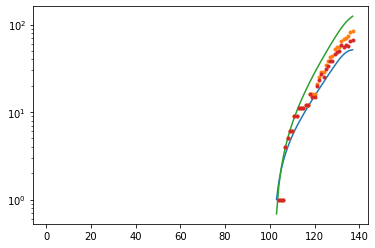

Aruba


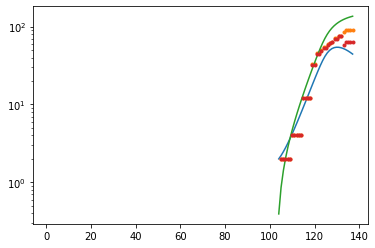

Nigeria


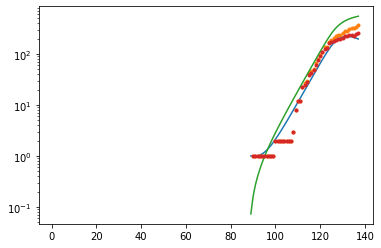

Belgium


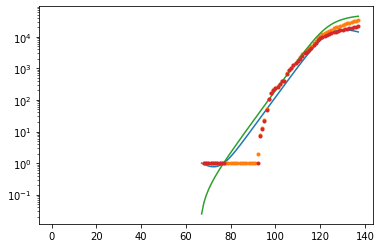

Saudi Arabia


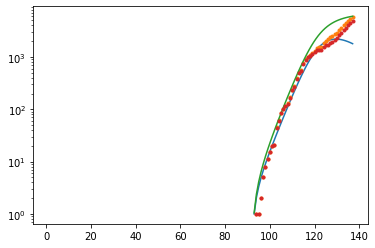

Cayman Islands


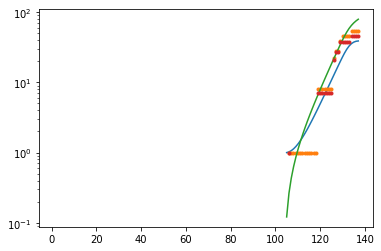

El Salvador


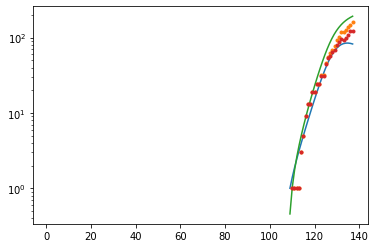

Chad


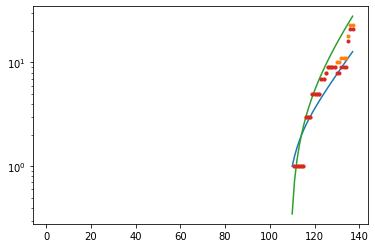

Papua New Guinea


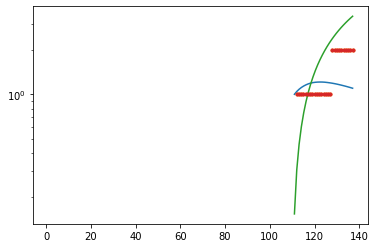

St. Kitts and Nevis


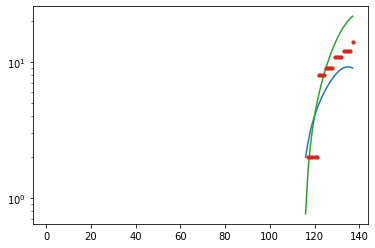

Cambodia


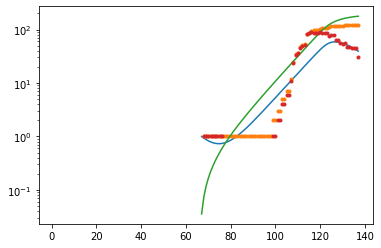

Guernsey


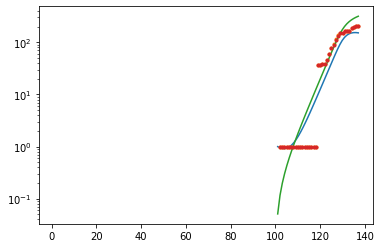

United States


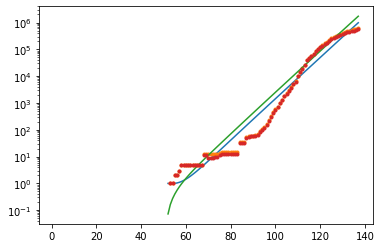

Portugal


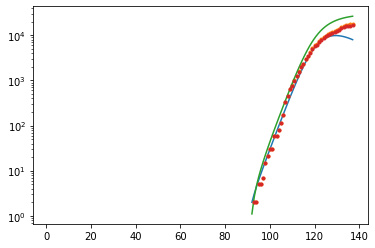

United States Virgin Islands


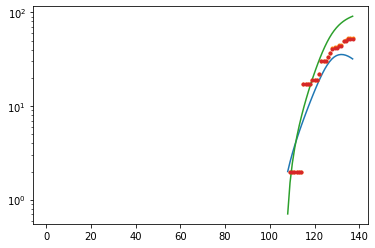

Brunei Darussalam


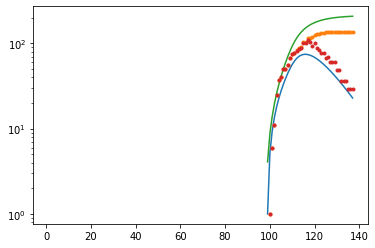

Hong Kong
Azerbaijan


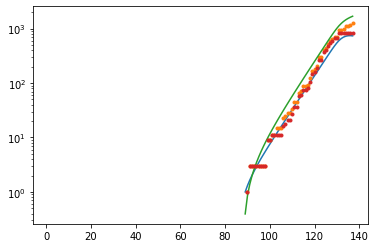

South Sudan
Kazakhstan


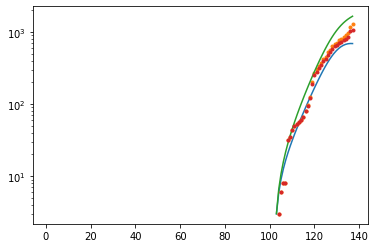

St. Lucia


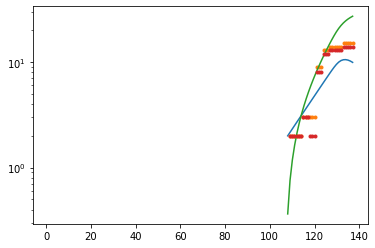

Belarus


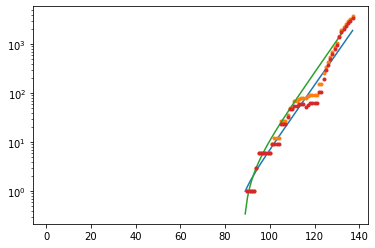

Tokelau
Cote d'Ivoire


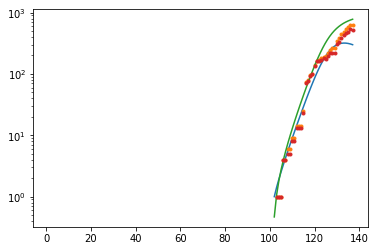

British Virgin Islands
France


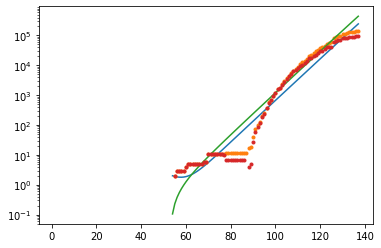

Tanzania


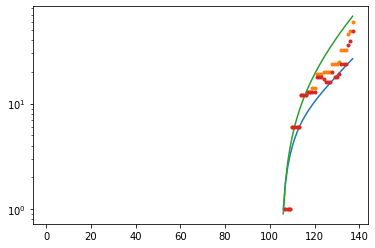

Colombia


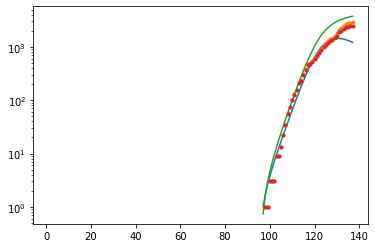

Serbia


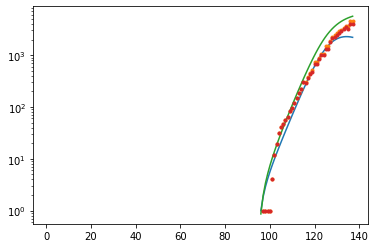

Jersey


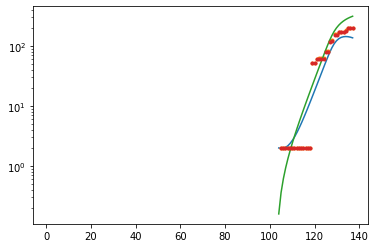

United States Minor Outlying Islands
Samoa
Falkland Islands


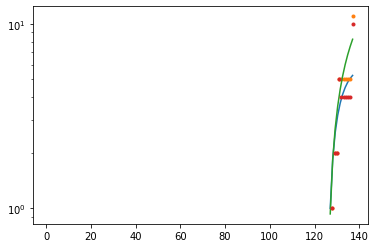

Costa Rica


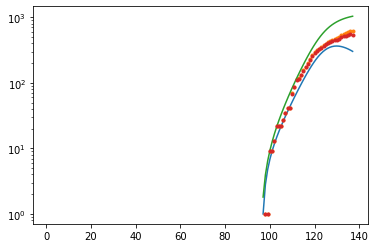

Latvia


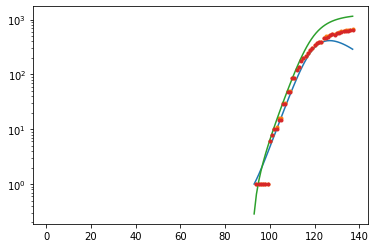

British Indian Ocean Territory
Macao
United Arab Emirates


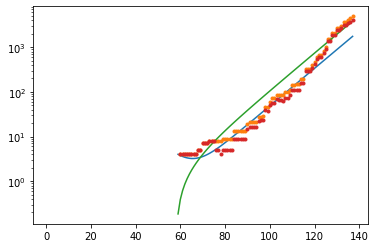

Brazil


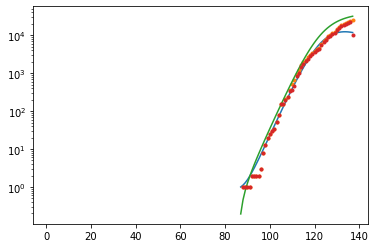

Western Sahara
Tunisia


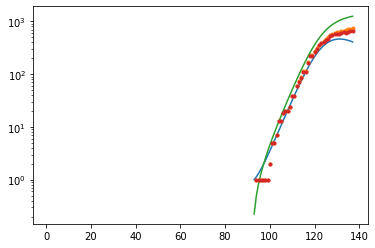

Andorra


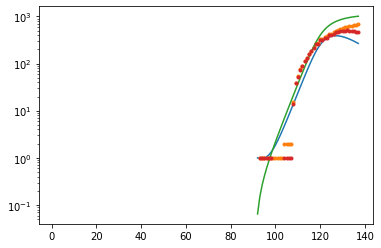

Bangladesh


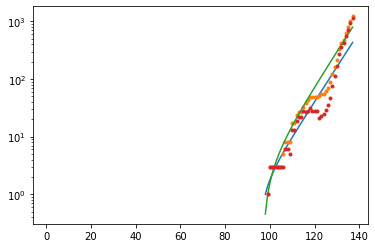

Egypt


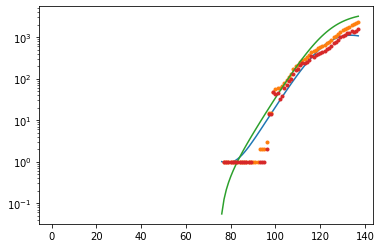

Taiwan
American Samoa
Guam


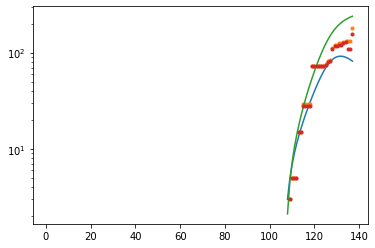

Morocco


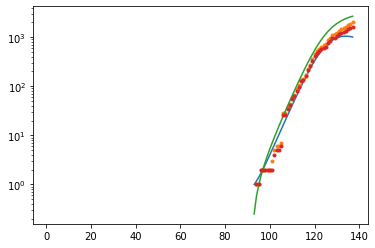

Palestine


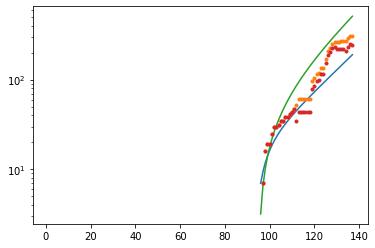

Togo


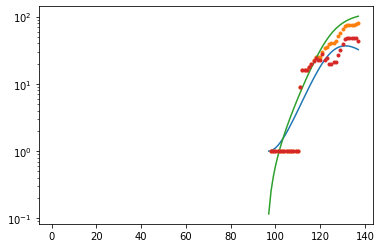

Qatar


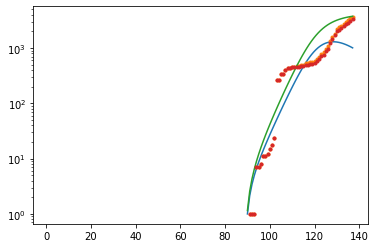

Belize


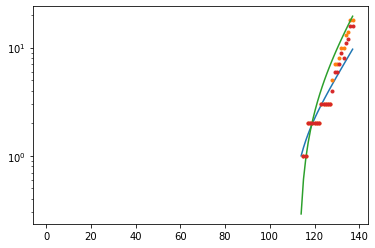

In [178]:
# 单独加载每个国家的参数，查看该国模拟结果
t_c = 8.3
t_r = 9.2
r0 = 2.3
initials = np.zeros(len(nodes))
alphas = np.zeros(len(nodes))
betas = np.zeros(len(nodes))
lambds = np.zeros(len(nodes))
t0s = np.zeros(len(nodes))
for i,(c,v) in enumerate(aaa.items()):
    initials[nodes[c]] = v['initial_unconfirmed'][0]
    alphas[nodes[c]]=v['alphas'][0]
    betas[nodes[c]]=v['betas'][0]
    t0s[nodes[c]]=v['t0s'][0]
    lambds[nodes[c]]=v['lambds'][0]

all_trajectories = np.zeros([all_cumconfirm_cases.shape[0], all_cumconfirm_cases.shape[1], 3])
epidemic_start_time = np.zeros(len(nodes))
for c,i in nodes.items():
    print(c)
    cumconfirm = np.nonzero(all_cumconfirm_cases[:,i])[0]
    if len(cumconfirm)> 0 :
        first_t = cumconfirm[0]
        epidemic_start_time[i] = first_t
        timeline = len(time_cases) - first_t
        timespan = np.linspace(0, timeline, timeline)
        cases_data = all_cumconfirm_cases[first_t:, i]
        cs0 = cases_data[0] / population[i]
        us0 = initials[i] / population[i]
        ss0 = 1 - cs0 - us0
        initial_state = np.r_[us0, cs0, ss0]
        t0ss = t0s[i] - first_t
        constants = {'beta': r0 / t_c, 'tc': t_c, 'tr': t_r, 'interval': 1,'tstar':0,'epsilon':0.001,'lambds2':0}
        constants['beta'] = betas[i]
        constants['alpha'] = alphas[i]
        constants['t0s'] = t0s[i]
        constants['lambds'] = lambds[i]

        result = odeint(single_np_ode, initial_state, timespan, args = (constants, population))
        partt = alphas[i] * result[:, 0] / (constants['tc'] * constants['interval'])
        partt = np.cumsum(partt)
        all_trajectories[first_t:len(time_cases), i, 0:2] = result[:, 0:2]
        all_trajectories[first_t:len(time_cases), i, 2] = partt
        plt.semilogy(first_t + timespan, result[:, 1] * population[i])
        plt.semilogy(np.linspace(1,len(time_cases), len(time_cases)), all_cumexist_cases[:, i],'.')
        plt.semilogy(first_t + timespan, partt * population[i])
        plt.semilogy(np.linspace(1,len(time_cases), len(time_cases)), all_cumconfirm_cases[:, i],'.')
        plt.show()

#输出一个数组all_trajectories，格式time_length*国家数*3，记录了任意时刻任意国家的未确诊、确诊和累积现存病例数

In [179]:
# 以all_trajectories最后一个时刻所记录的数据作为初始条件，开始模拟每个国家的增长情况
t_c = 8.3
t_r = 9.2
r0 = 2.3

timespan = np.linspace(len(time_cases), len(fijt), len(fijt) - len(time_cases))
constants = {'beta': r0 / t_c, 'tc': t_c, 'tr': t_r, 'interval': 1,'tstar':0,'epsilon':0.001,'lambds2':0}


us00 = all_trajectories[-1, :,0]
cs00 = all_trajectories[-1, :,1]
ss00 = 1 - us00 - cs00
virus_influx0 = np.zeros(len(nodes))
domestic_flux0 = np.zeros(len(nodes))
initial_states = np.r_[us00,cs00,ss00,virus_influx0,domestic_flux0]
params = constants
params['beta'] = betas
params['alphas'] = alphas
params['t0s'] = t0s + epidemic_start_time
params['lambds'] = lambds
result = odeint(np_ode, initial_states, timespan, args = (params, fijt, population))


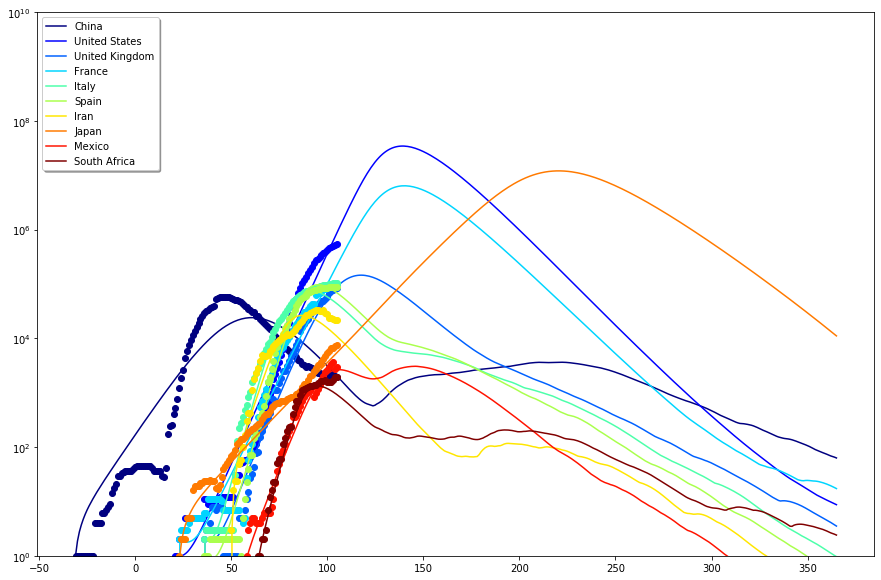

In [180]:
# 挑选了若干个代表性国家，绘制它们的疫情增长曲线
plt.figure(figsize = (15,10))
countries = ['China','United States','United Kingdom','France','Italy','Spain','Iran','Japan','Mexico','South Africa']
colors = plt.cm.jet(np.linspace(0,1,len(countries)))
plot_time = np.linspace(0, len(fijt), len(fijt)-1)

for i,country in enumerate(countries):
    row = nodes.get(country, -1)
    pop = population[nodes[country]]
    #try:
    show = np.r_[all_trajectories[:, row, 1] ,result[1:, len(nodes)+row]]
    show = show * pop
    #show = result[:,  row] * pop
    plt.semilogy(plot_time-(first_date - start_date).days, show, '-', color = colors[i], label=country)
    plt.semilogy(np.arange(all_cumconfirm_cases.shape[0])-(first_date - start_date).days
                 , all_cumconfirm_cases[:, row], 'o', color = colors[i])
    

plt.legend(loc='upper left', shadow=True, numpoints = 1,fontsize=10)
plt.ylim([1, 10**10])
plt.show()

In [181]:
print(t0s[nodes['Japan']]+epidemic_start_time[nodes['Japan']], lambds[nodes['Japan']], 
t0s[nodes['China']]+epidemic_start_time[nodes['China']],lambds[nodes['China']])

58.81440591812134 0.018041856586933136 0.0 0.08126427233219147


### Inter-country virus export matrix

In [182]:
# 计算任意国家到任意国家的病例输入数据
influence_matrix = []
for t in range(result.shape[0]):
    fluxmatrix = [row *population[i]  for i,row in enumerate(fijt[t])]
    aa=np.transpose(np.repeat(np.array([result[t,:len(nodes)]]), len(nodes), axis=0))
    i2j_virus_flux = aa*fluxmatrix
    influence_matrix.append(i2j_virus_flux)

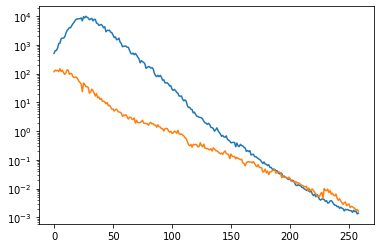

In [183]:
ploty=[]
ploty1=[]
for t in range(len(influence_matrix)):
    ploty.append(influence_matrix[t][nodes['United States'],:].sum())
    ploty1.append(influence_matrix[t][nodes['United Kingdom'],:].sum())
plt.semilogy(ploty)
plt.semilogy(ploty1)

In [184]:
ids = np.argsort(total_influence[:, nodes['China']])[::-1]
sort_china = []
for ii in ids:
    for c,i in nodes.items():
        if ii==i:
            sort_china.append(c)
sort_china

['United States',
 'Japan',
 'Australia',
 'Singapore',
 'Malaysia',
 'France',
 'United Arab Emirates',
 'Russia',
 'Canada',
 'Philippines',
 'Myanmar',
 'India',
 'Sri Lanka',
 'Belarus',
 'Finland',
 'Hong Kong',
 'Bangladesh',
 'United Kingdom',
 'Oman',
 'Germany',
 'Nepal',
 'South Korea',
 'Taiwan',
 'Thailand',
 'New Zealand',
 'Netherlands',
 'Maldives',
 'Spain',
 'Laos',
 'Qatar',
 'Italy',
 'Belgium',
 'Switzerland',
 'Vietnam',
 'Austria',
 'Turkey',
 'Israel',
 'Cambodia',
 'Denmark',
 'Sweden',
 'Portugal',
 'Uzbekistan',
 'Indonesia',
 'Czech Republic',
 'Saudi Arabia',
 'Brunei Darussalam',
 'Reunion',
 'Azerbaijan',
 'Hungary',
 'Ethiopia',
 'Greece',
 'Egypt',
 'Mauritius',
 'Northern Mariana Islands',
 'South Africa',
 'Iran',
 'Poland',
 'Kazakhstan',
 'Kyrgyz Republic',
 'Algeria',
 'Cuba',
 'Brazil',
 'Kenya',
 'Tajikistan',
 'Ukraine',
 'Mongolia',
 'Mexico',
 'Pakistan',
 'Georgia',
 'Morocco',
 'Madagascar',
 'Rwanda',
 'Panama',
 'Afghanistan',
 'Turkmenista

['United States', 'France', 'United Arab Emirates', 'Australia', 'Canada', 'India', 'Singapore', 'Japan', 'Russia', 'Malaysia', 'Vietnam', 'Philippines', 'Oman', 'Sri Lanka', 'Kuwait', 'Bahrain', 'Bangladesh', 'Belarus', 'Myanmar', 'United Kingdom', 'Tanzania', 'Sudan', 'Gabon', 'Germany', 'Belize', 'Somalia', 'Qatar', 'Chad', 'Netherlands', 'Liberia', 'Hong Kong', 'Spain', 'Finland', 'New Zealand', 'Seychelles', 'Switzerland', 'Guyana', 'Thailand', 'Ireland', 'St. Vincent and the Grenadines', 'Italy', 'Maldives', 'Portugal', 'Turks and Caicos Islands', 'Belgium', 'Taiwan', 'South Korea', 'Denmark', 'Austria', 'Puerto Rico', 'Panama', 'Nicaragua', 'United States Virgin Islands', 'Aruba', 'Turkey', 'Iceland', 'Falkland Islands', 'Sint Maarten', 'Sweden', 'Saudi Arabia', 'Bahamas', 'Guam', 'Botswana', 'Mexico', 'Norway', 'Israel', 'Laos', 'Czech Republic', 'Greece', 'Malta', 'Cyprus', 'Zimbabwe', 'Luxembourg', 'Cayman Islands', 'Guadeloupe', 'Antigua and Barbuda', 'Peru', 'Latvia', 'Domi

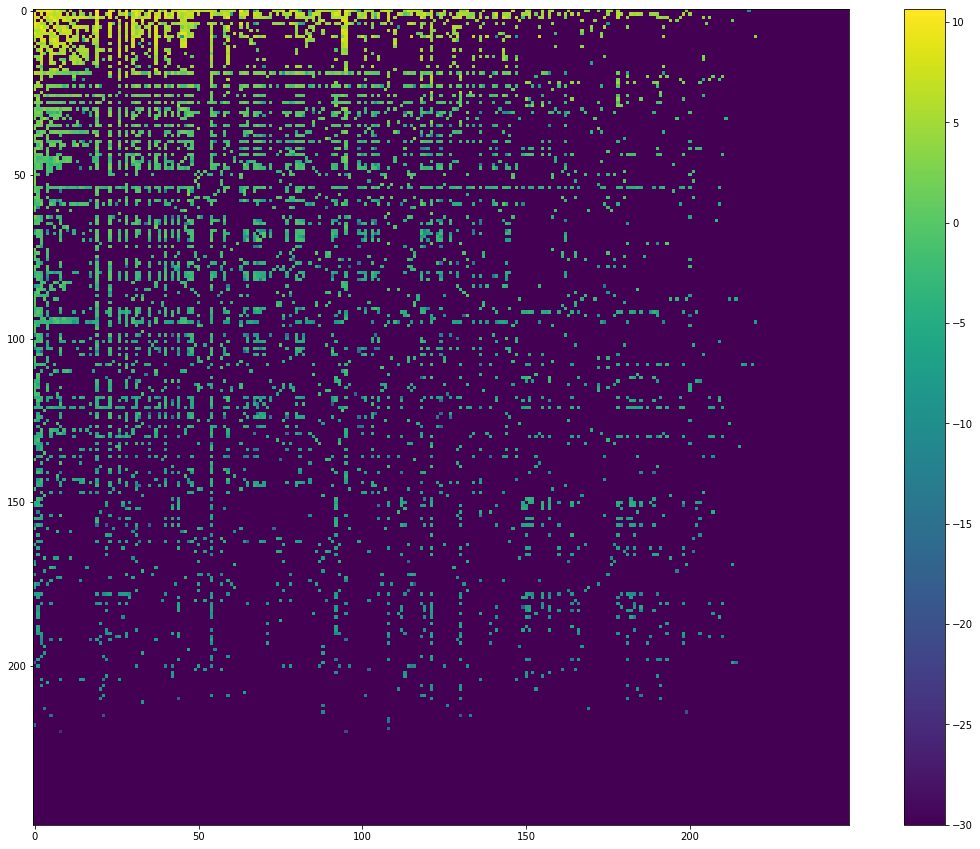

In [185]:
total_influence = np.array(influence_matrix).sum(0)
out_influence = total_influence.sum(1)
ids=np.argsort(out_influence)[::-1]
sort_countries = []
for ii in ids:
    for c,i in nodes.items():
        if ii==i:
            sort_countries.append(c)
    
print(sort_countries)
#bools = total_influence<1
bools = total_influence==0
#total_influence[bools]=0
total_influence[~bools] = np.log(total_influence[~bools])
total_influence[bools] = -30
ordered = np.zeros(total_influence.shape)
for i,row in enumerate(total_influence):
    ordered[i,:]=total_influence[ids[i], ids]
plt.figure(figsize=(20,15))
plt.imshow(ordered)
plt.colorbar()
plt.show()

### Domestic v.s. Import For Selected Country

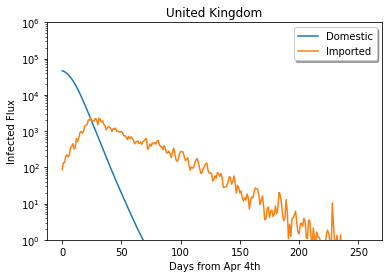

In [186]:
#infected_newly = np.diff(result[:, nodes['China']])
imported_newly = np.diff(result[:, 3 * len(nodes)+nodes['United Kingdom']])
domestic_newly = np.diff(result[:, 4 * len(nodes) + nodes['United Kingdom']])
#plt.plot(infected_newly*population[nodes['China']])
plt.semilogy(domestic_newly*population[nodes['United Kingdom']], label='Domestic')
plt.semilogy(imported_newly*population[nodes['United Kingdom']], label='Imported')
plt.ylim([1, 10**6])
plt.xlabel('Days from Apr 4th')
plt.ylabel('Infected Flux')
plt.title('United Kingdom')
plt.legend(loc='upper right', shadow=True, numpoints = 1,fontsize=10)